# WORLD.jl

A brief introduction to WORLD.jl, which provides you to analyze and synthesis speech signals.

https://github.com/r9y9/WORLD.jl

In [1]:
using WORLD
using WAV

In [2]:
using PyCall
using PyPlot
PyDict(matplotlib["rcParams"])["figure.figsize"] = (12, 4);
save_fig = false

false

## Data

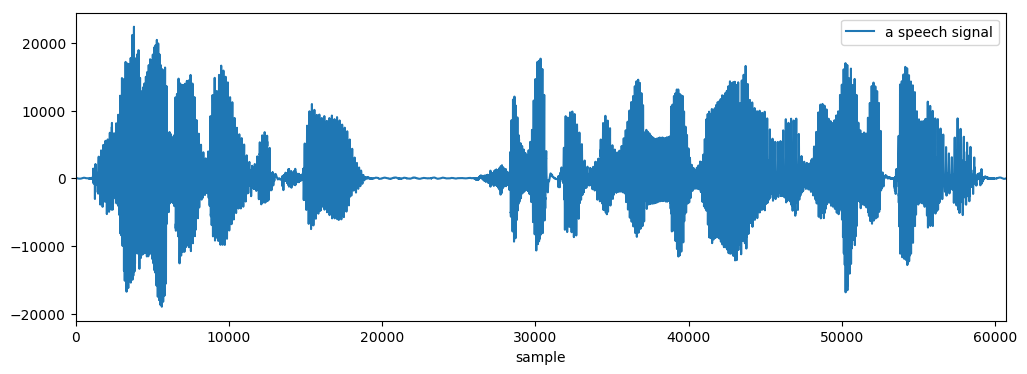

WAV.WAVArray{Int16,1}(16000, Int16[38, 63, 57, 63, 56, 59, 56, 59, 57, 58  …  -44, -46, -44, -44, -44, -46, -44, -43, -41, -46])

In [3]:
filepath = joinpath(Pkg.dir("WORLD"), "test", "data", "test16k.wav")
x, fs = wavread(filepath, format="native")
x = map(Float64, vec(x)) # monoral
fs = convert(Int, fs)

# Visualize the speech signal in time-domain
plot(1:endof(x), x, label="a speech signal")
xlim(1, endof(x))
xlabel("sample")
legend()
save_fig && savefig("x.png")

WAVArray(fs, trunc.(Int16, x))

## F0 estimation by Harvest

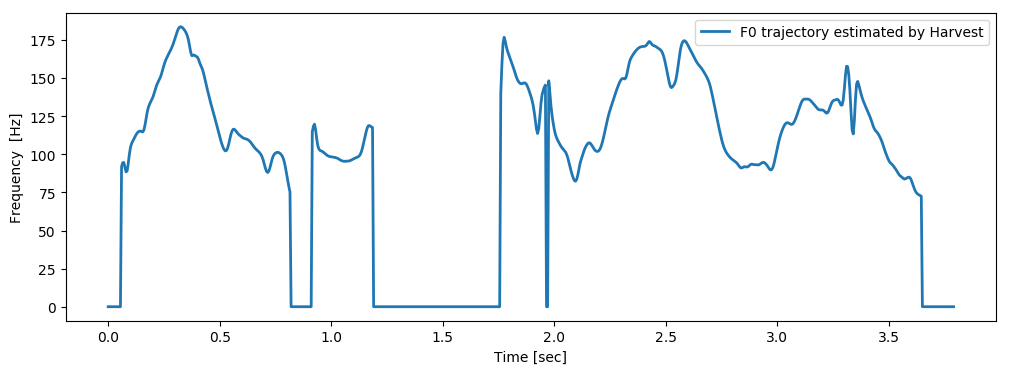

false

In [4]:
period = 5.0
opt = HarvestOption(71.0, 800.0, period)
f0, timeaxis = harvest(x, fs, opt)

plot(timeaxis, f0, label="F0 trajectory estimated by Harvest", linewidth=2)
xlabel("Time [sec]")
ylabel("Frequency  [Hz]")
legend();
save_fig && savefig("f0_by_harvest.png")

## Spectral envelope estimatino by CheapTrick

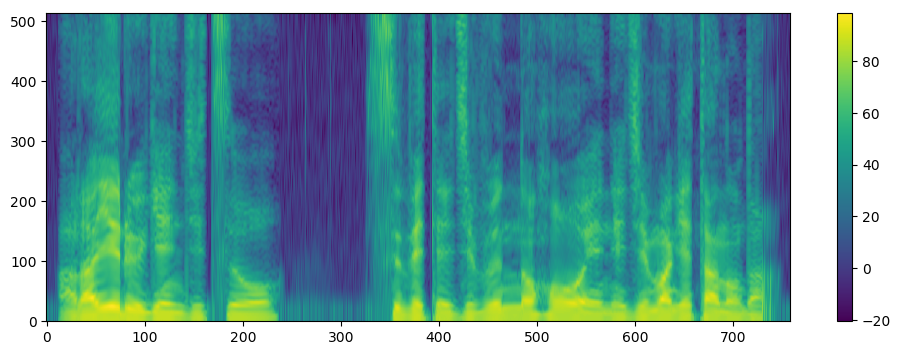

false

In [5]:
spectrogram = cheaptrick(x, fs, timeaxis, f0)

imshow(10log10.(spectrogram), origin="lower", aspect="auto")
colorbar();
save_fig && savefig("envelope_by_cheaptrick.png")

## Aperiodicity ratio estimation

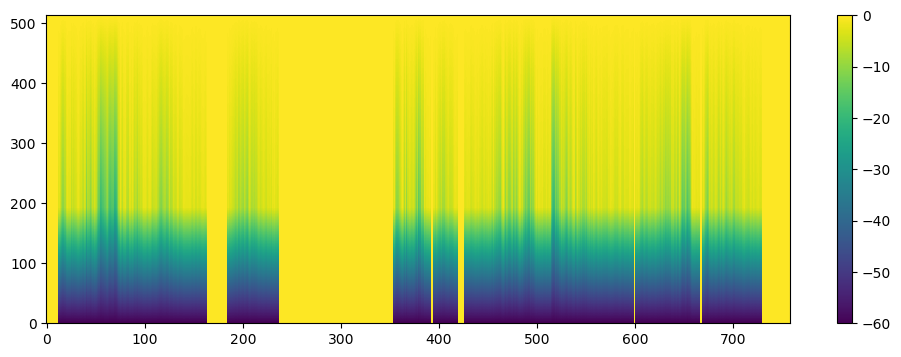

false

In [6]:
aperiodicity = d4c(x, fs, timeaxis, f0)

imshow(20log10.(aperiodicity), origin="lower", aspect="auto")
colorbar();
save_fig && savefig("aperiodicity_by_d4c.png")

## Sysnthesis from f0, spectral envelope and aperiodicity

Mean error: 0.13748741973297338


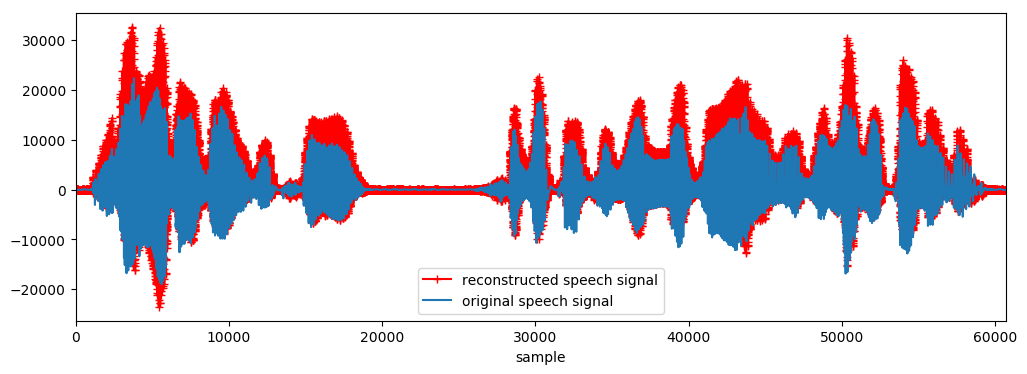

WAV.WAVArray{Int16,1}(16000, Int16[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  -7, -6, -8, -6, -5, -6, -6, -5, -5, 24])

In [7]:
y = synthesis(f0, spectrogram, aperiodicity, period, fs, length(x))
y = clamp.(y, typemin(Int16), typemax(Int16))
println("Mean error: ", mean(abs.(y-x))/maximum(abs, x));

plot(1:endof(y), y, "r-+", label="reconstructed speech signal")
plot(1:endof(x), x, label="original speech signal")
xlim(1, endof(y))
xlabel("sample")
legend()
save_fig && savefig("synthesis.png")
WAVArray(fs, trunc.(Int16, y))

## Compact speech parameterization

Raw spectrum envelop and aperiodicity spectrum are relatively high dimentional (offen more than 513 or 1023) so one might want to get more compact representation. To do so, mel-cepstrum could be a good choice. As far as I know, this would be useful in statistical speech synthesis and statistical voice conversion.

### Conversion between spectrum envelope and mel-cepstrum

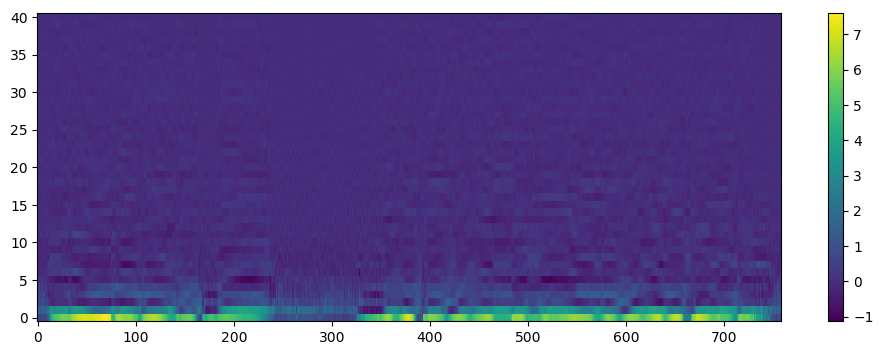

false

In [8]:
α = 0.41
fftlen = get_fftsize_for_cheaptrick(fs)
order = 40

# Feature dimention reduces to 41 from 513!
mc = sp2mc(spectrogram, order, α)

imshow(mc, origin="lower", aspect="auto")
colorbar();
save_fig && savefig("melcepstrum.png")

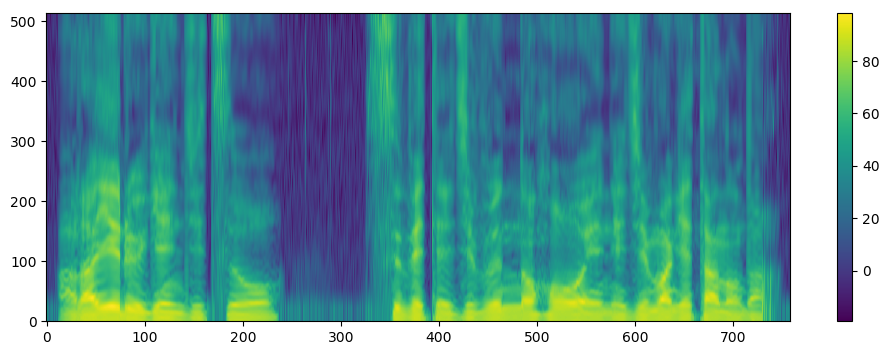

false

In [9]:
approximate_spectrogram = mc2sp(mc, α, fftlen)

imshow(10log10.(approximate_spectrogram), origin="lower", aspect="auto")
colorbar();
save_fig && savefig("envelope_reconstructed_from_melcepstrum.png")

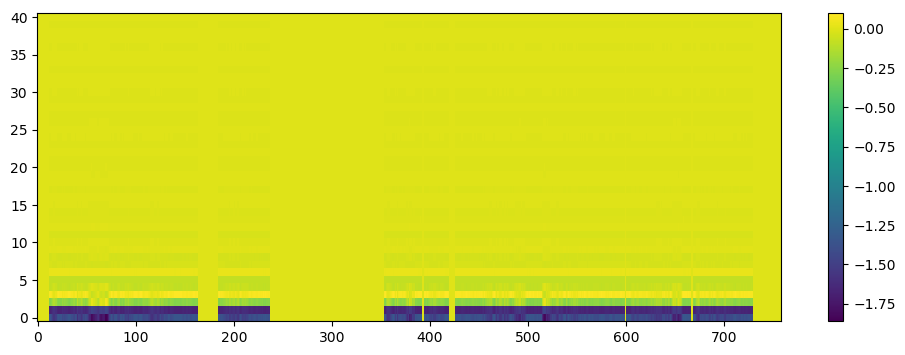

false

In [10]:
α = 0.41
fftlen = get_fftsize_for_cheaptrick(fs)
order = 40

mc_ap = sp2mc(aperiodicity, order, α)

imshow(mc_ap, origin="lower", aspect="auto")
colorbar();
save_fig && savefig("aperiodicity_melcepstrum.png")

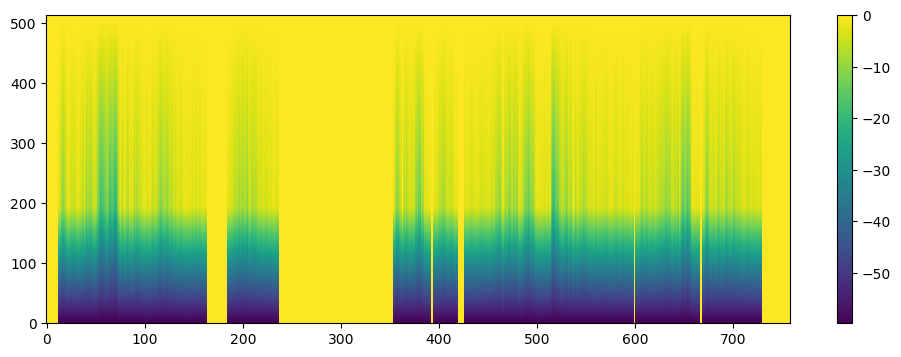

false

In [11]:
approximate_aperiodicity = mc2sp(mc_ap, α, fftlen)

imshow(20log10.(approximate_aperiodicity), origin="lower", aspect="auto")
colorbar();
save_fig && savefig("approximate_aperiodicity.png")

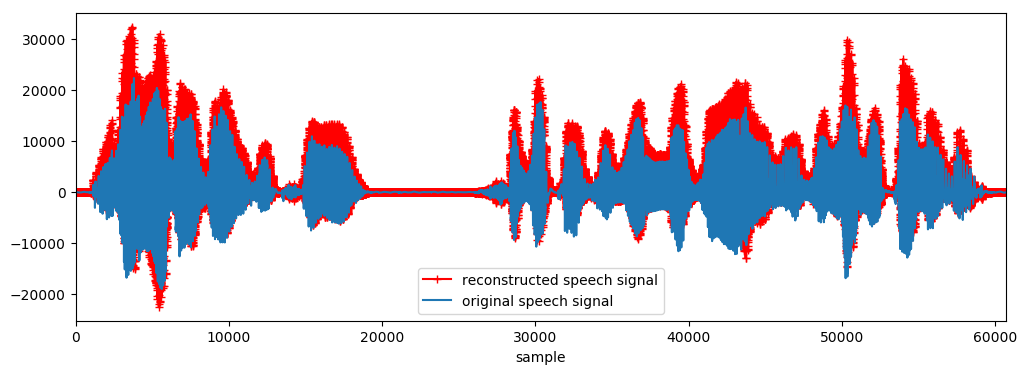

Mean error: 0.13667313992799598


WAV.WAVArray{Int16,1}(16000, Int16[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 2, 3, 2, 4, 4, 4, 6, 6, 50])

In [12]:
y_hat = synthesis(f0, approximate_spectrogram, approximate_aperiodicity, period, fs, length(x))
y_hat = clamp.(y_hat, typemin(Int16), typemax(Int16))
println("Mean error: ", mean(abs.(y_hat-x))/maximum(abs, x))

plot(1:endof(y_hat), y_hat, "r-+", label="reconstructed speech signal")
plot(1:endof(x), x, label="original speech signal")
xlim(1, endof(y_hat))
xlabel("sample")
legend()
WAVArray(fs, trunc.(Int16, y_hat))

## F0 estimation by DIo

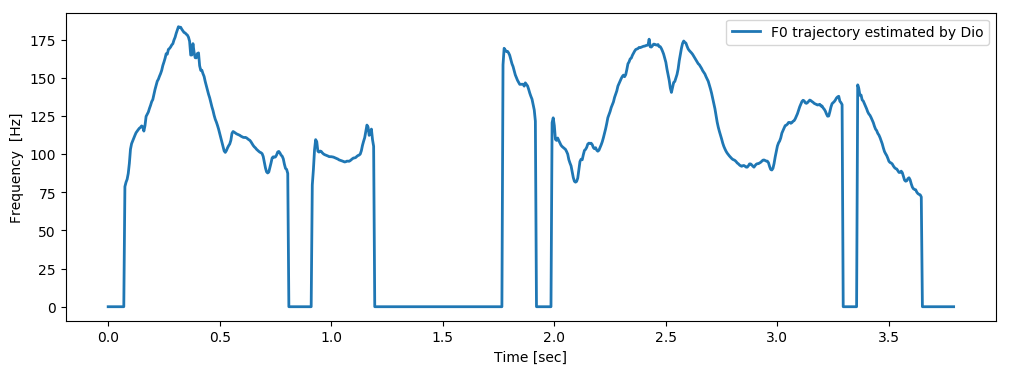

false

In [13]:
dioopt = DioOption(f0floor=71.0, f0ceil=800.0, channels_in_octave=2.0,
        period=period, speed=1)
f0, timeaxis = dio(x, fs, dioopt)

plot(timeaxis, f0, label="F0 trajectory estimated by Dio", linewidth=2)
xlabel("Time [sec]")
ylabel("Frequency  [Hz]")
legend();
save_fig && savefig("f0_by_dio.png")

## F0 refinement by Stonemask

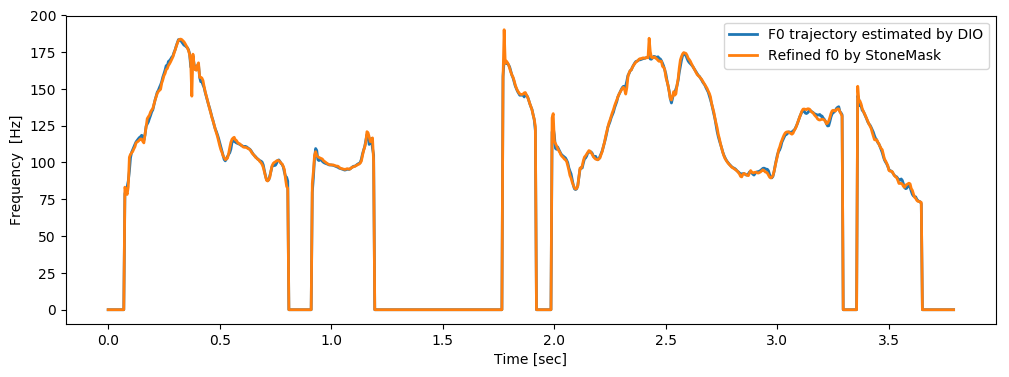

false

In [14]:
f0_by_dio = copy(f0)

# F0 refinement by StoneMask
f0 = stonemask(x, fs, timeaxis, f0_by_dio)

plot(timeaxis, f0_by_dio, label="F0 trajectory estimated by DIO", linewidth=2)
plot(timeaxis, f0, label="Refined f0 by StoneMask", linewidth=2)
xlabel("Time [sec]")
ylabel("Frequency  [Hz]")
legend()
save_fig && savefig("f0_refinement.png")